# UniVI CITE-seq data integration demonstration/tutorial - Forced disjoint cell proportions in each different modality, then matching and training a UniVI model using those matches

Andrew Ashford, Pathways + Omics Group, Oregon Health & Science University - 11/18/2025

This Jupyter Notebook will be used to outline the training steps for a UniVI model using human PBMC CITE-seq data. This is a copy of the other version that will be used to test an approach which we artificially "pair" the cells prior to training using a bipartite matching approach, since the model requires paired samples to train. This approach might be able to circumvent the necessity of paired cells between modalities for training a robust integration model.


#### Import modules

In [1]:
import os, sys, json
import numpy as np
import scanpy as sc
import torch


In [2]:
# -------------------------
# 0. Wire up package import
# -------------------------
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.append(project_root)

from univi import (
    UniVIMultiModalVAE,
    ModalityConfig,
    UniVIConfig,
    TrainingConfig,
    matching,
)
from univi.data import MultiModalDataset
from univi.trainer import UniVITrainer


#### Read in and preprocess data as needed

In [3]:
# -------------------------
# 1. Load AnnData objects
# -------------------------
# Load RNA AnnData object
rna_adata = sc.read_h5ad("../data/Hao_CITE-seq_data/Hao_RNA_data.h5ad")


/home/groups/precepts/ashforda/anaconda3/envs/UniVI_working_environment_v2/lib/python3.8/site-packages/anndata/compat/__init__.py:229: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(


In [4]:
# Sanity check
print(rna_adata)
print(rna_adata.X)
print(rna_adata.X.min())
print(rna_adata.X.max())


AnnData object with n_obs × n_vars = 161764 × 20729
    obs: 'nCount_ADT', 'nFeature_ADT', 'nCount_RNA', 'nFeature_RNA', 'orig.ident', 'lane', 'donor', 'time', 'celltype.l1', 'celltype.l2', 'celltype.l3', 'Phase', 'nCount_SCT', 'nFeature_SCT'
    var: 'features'
    uns: 'neighbors'
    obsm: 'X_apca', 'X_aumap', 'X_pca', 'X_spca', 'X_umap', 'X_wnn.umap'
    varm: 'PCs', 'SPCA'
    obsp: 'distances'
  (0, 1)	0.6931471805599453
  (0, 19)	0.6931471805599453
  (0, 23)	0.6931471805599453
  (0, 28)	0.6931471805599453
  (0, 30)	1.3862943611198906
  (0, 48)	0.6931471805599453
  (0, 49)	1.3862943611198906
  (0, 54)	0.6931471805599453
  (0, 57)	1.0986122886681096
  (0, 63)	0.6931471805599453
  (0, 82)	2.1972245773362196
  (0, 98)	0.6931471805599453
  (0, 99)	0.6931471805599453
  (0, 111)	1.791759469228055
  (0, 127)	0.6931471805599453
  (0, 138)	0.6931471805599453
  (0, 149)	0.6931471805599453
  (0, 151)	1.6094379124341003
  (0, 157)	0.6931471805599453
  (0, 159)	0.6931471805599453
  (0, 160)	0

In [5]:
# Change the RNA counts to raw counts so they're not log-normalized and use ZINB or NB as the decoder distribution
# for model training
rna_adata.layers['log1p'] = rna_adata.X
rna_adata.X = rna_adata.raw.X


In [6]:
# Sanity check
print(rna_adata.X)
print(rna_adata.X.min())
print(rna_adata.X.max())


  (0, 1)	1.0
  (0, 19)	1.0
  (0, 23)	1.0
  (0, 28)	1.0
  (0, 30)	3.0
  (0, 48)	1.0
  (0, 49)	3.0
  (0, 54)	1.0
  (0, 57)	2.0
  (0, 63)	1.0
  (0, 82)	8.0
  (0, 98)	1.0
  (0, 99)	1.0
  (0, 111)	5.0
  (0, 127)	1.0
  (0, 138)	1.0
  (0, 149)	1.0
  (0, 151)	4.0
  (0, 157)	1.0
  (0, 159)	1.0
  (0, 160)	1.0
  (0, 161)	1.0
  (0, 162)	1.0
  (0, 170)	2.0
  (0, 182)	1.0
  :	:
  (161763, 16110)	4.0
  (161763, 16113)	4.0
  (161763, 16130)	1.0
  (161763, 16158)	3.0
  (161763, 16159)	4.0
  (161763, 16160)	8.0
  (161763, 16163)	1.0
  (161763, 16184)	33.0
  (161763, 16185)	34.0
  (161763, 16186)	99.0
  (161763, 16187)	72.0
  (161763, 16188)	1.0
  (161763, 16189)	64.0
  (161763, 16190)	75.0
  (161763, 16191)	53.0
  (161763, 16193)	31.0
  (161763, 16194)	9.0
  (161763, 16196)	51.0
  (161763, 16350)	1.0
  (161763, 16585)	1.0
  (161763, 16688)	1.0
  (161763, 17511)	1.0
  (161763, 17866)	3.0
  (161763, 18249)	1.0
  (161763, 18702)	1.0
0.0
8513.0


In [7]:
# If your counts are in rna_adata.X (raw or log-normalized), this is fine:
sc.pp.highly_variable_genes(
    rna_adata,
    layer='log1p',
    n_top_genes=2000,
    flavor="seurat",   # or "cell_ranger" / "seurat_v3"
    inplace=True,
)


In [8]:
# Boolean mask of HVGs
hvg_mask = rna_adata.var["highly_variable"].values

# Names of the top HVGs
hvg_genes = rna_adata.var_names[hvg_mask].tolist()
print(f"Selected {len(hvg_genes)} highly variable genes.")
print(hvg_genes[:20])  # peek at first few


Selected 2000 highly variable genes.
['HES4', 'ISG15', 'TNFRSF18', 'TNFRSF4', 'RBP7', 'EPHA2', 'PADI4', 'CDA', 'EIF4G3', 'AL031005.1', 'C1QA', 'C1QC', 'C1QB', 'TCEA3', 'ID3', 'RCAN3', 'LDLRAP1', 'STMN1', 'ZNF683', 'IFI6']


In [9]:
# Optional: make a HVG-only AnnData for modeling
rna_adata_hvg = rna_adata[:, hvg_mask].copy()
print(rna_adata_hvg)


AnnData object with n_obs × n_vars = 161764 × 2000
    obs: 'nCount_ADT', 'nFeature_ADT', 'nCount_RNA', 'nFeature_RNA', 'orig.ident', 'lane', 'donor', 'time', 'celltype.l1', 'celltype.l2', 'celltype.l3', 'Phase', 'nCount_SCT', 'nFeature_SCT'
    var: 'features', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'neighbors', 'hvg'
    obsm: 'X_apca', 'X_aumap', 'X_pca', 'X_spca', 'X_umap', 'X_wnn.umap'
    varm: 'PCs', 'SPCA'
    layers: 'log1p'
    obsp: 'distances'


In [10]:
# Load ADT AnnData object
adt_adata = sc.read_h5ad("../data/Hao_CITE-seq_data/Hao_ADT_data.h5ad")


In [11]:
# Sanity check
print(adt_adata)
print(adt_adata.X)
print(adt_adata.X.min())
print(adt_adata.X.max())


AnnData object with n_obs × n_vars = 161764 × 228
    obs: 'nCount_ADT', 'nFeature_ADT', 'nCount_RNA', 'nFeature_RNA', 'orig.ident', 'lane', 'donor', 'time', 'celltype.l1', 'celltype.l2', 'celltype.l3', 'Phase', 'nCount_SCT', 'nFeature_SCT'
    var: 'features'
    obsm: 'X_apca', 'X_aumap', 'X_pca', 'X_spca', 'X_umap', 'X_wnn.umap'
    varm: 'APCA'
[[1.95916424 0.86914159 1.48523314 ... 0.55307644 1.04608444 1.72565693]
 [0.4322284  1.01422751 0.79594998 ... 0.66587988 0.85514588 1.37971736]
 [0.61381759 1.30390619 0.75610373 ... 0.6874892  0.75610373 1.04246048]
 ...
 [1.50685426 0.54914608 1.0656108  ... 0.25674036 0.25674036 1.16168749]
 [1.63537843 0.32520632 1.19570797 ... 0.45519093 0.51435145 2.10485699]
 [1.58503    0.64458811 1.61118685 ... 0.416905   0.23002318 2.07731277]]
0.0
8.589231339100166


In [12]:
# Set the ADT data to raw counts and use a NB or ZINB decoder in model training and save the current .X counts to
# .layers['log1p']
adt_adata.layers['log1p'] = adt_adata.X
adt_adata.X = adt_adata.raw.X


In [13]:
# Sanity check
print(adt_adata)
print(adt_adata.X)
print(adt_adata.X.min())
print(adt_adata.X.max())


AnnData object with n_obs × n_vars = 161764 × 228
    obs: 'nCount_ADT', 'nFeature_ADT', 'nCount_RNA', 'nFeature_RNA', 'orig.ident', 'lane', 'donor', 'time', 'celltype.l1', 'celltype.l2', 'celltype.l3', 'Phase', 'nCount_SCT', 'nFeature_SCT'
    var: 'features'
    obsm: 'X_apca', 'X_aumap', 'X_pca', 'X_spca', 'X_umap', 'X_wnn.umap'
    varm: 'APCA'
    layers: 'log1p'
  (0, 0)	66.0
  (0, 1)	15.0
  (0, 2)	37.0
  (0, 3)	142.0
  (0, 4)	4.0
  (0, 5)	3.0
  (0, 6)	242.0
  (0, 7)	9.0
  (0, 8)	752.0
  (0, 9)	14.0
  (0, 10)	5.0
  (0, 11)	3.0
  (0, 13)	20.0
  (0, 14)	8.0
  (0, 15)	4.0
  (0, 16)	1.0
  (0, 17)	5.0
  (0, 18)	4.0
  (0, 19)	2.0
  (0, 20)	5.0
  (0, 21)	28.0
  (0, 22)	1.0
  (0, 23)	12.0
  (0, 24)	479.0
  (0, 25)	6.0
  :	:
  (161763, 203)	3.0
  (161763, 204)	2.0
  (161763, 205)	3.0
  (161763, 206)	34.0
  (161763, 207)	149.0
  (161763, 208)	38.0
  (161763, 209)	23.0
  (161763, 210)	79.0
  (161763, 211)	3.0
  (161763, 212)	109.0
  (161763, 213)	13.0
  (161763, 214)	5.0
  (161763, 215)	1.0

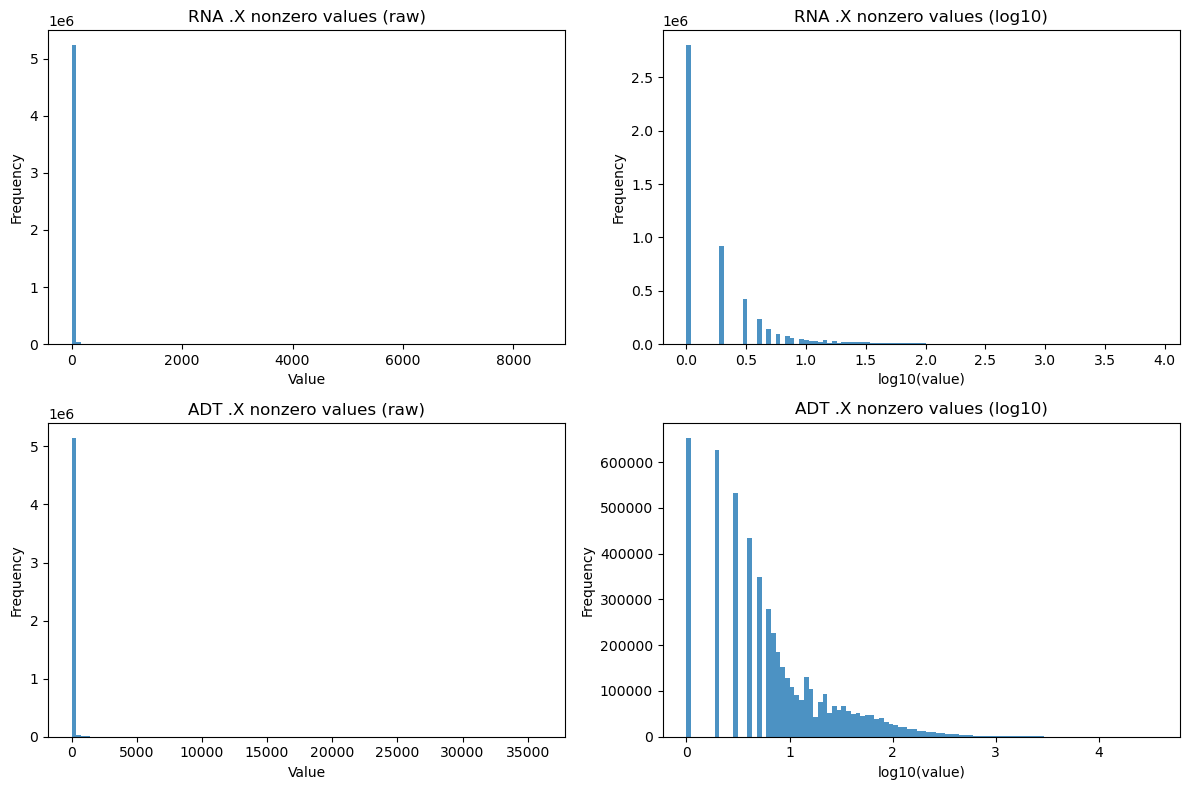

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse

def get_X_values(adata, n_cells: int = 5000):
    """
    Return flattened values from adata.X (optionally subsampled over cells).
    Uses only non-zero entries if X is sparse.
    """
    X = adata.X

    # Optional subsampling over cells (rows)
    if n_cells is not None and adata.n_obs > n_cells:
        idx = np.random.choice(adata.n_obs, size=n_cells, replace=False)
        X = X[idx]

    if sparse.issparse(X):
        vals = X.data  # nonzero values
    else:
        vals = np.asarray(X).ravel()

    # Remove zeros explicitly (just to focus on count/ADT magnitude)
    vals = vals[vals > 0]
    return vals

def plot_X_distribution(rna_adata, adt_adata, n_cells: int = 5000):
    rna_vals = get_X_values(rna_adata, n_cells=n_cells)
    adt_vals = get_X_values(adt_adata, n_cells=n_cells)

    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    
    # --- RNA raw ---
    axes[0, 0].hist(rna_vals, bins=100, alpha=0.8)
    axes[0, 0].set_title("RNA .X nonzero values (raw)")
    axes[0, 0].set_xlabel("Value")
    axes[0, 0].set_ylabel("Frequency")

    # --- RNA log10 ---
    axes[0, 1].hist(np.log10(rna_vals + 1e-8), bins=100, alpha=0.8)
    axes[0, 1].set_title("RNA .X nonzero values (log10)")
    axes[0, 1].set_xlabel("log10(value)")
    axes[0, 1].set_ylabel("Frequency")

    # --- ADT raw ---
    axes[1, 0].hist(adt_vals, bins=100, alpha=0.8)
    axes[1, 0].set_title("ADT .X nonzero values (raw)")
    axes[1, 0].set_xlabel("Value")
    axes[1, 0].set_ylabel("Frequency")

    # --- ADT log10 ---
    axes[1, 1].hist(np.log10(adt_vals + 1e-8), bins=100, alpha=0.8)
    axes[1, 1].set_title("ADT .X nonzero values (log10)")
    axes[1, 1].set_xlabel("log10(value)")
    axes[1, 1].set_ylabel("Frequency")

    plt.tight_layout()
    plt.show()

# Call it:
plot_X_distribution(rna_adata_hvg, adt_adata, n_cells=25000)


In [15]:
print(rna_adata_hvg)
print(set(rna_adata_hvg.obs['celltype.l1']))
print(rna_adata_hvg.obs['celltype.l1'].value_counts())
print(set(rna_adata_hvg.obs['celltype.l2']))
print(rna_adata_hvg.obs['celltype.l2'].value_counts())
print(set(rna_adata_hvg.obs['celltype.l3']))
print(rna_adata_hvg.obs['celltype.l3'].value_counts())


AnnData object with n_obs × n_vars = 161764 × 2000
    obs: 'nCount_ADT', 'nFeature_ADT', 'nCount_RNA', 'nFeature_RNA', 'orig.ident', 'lane', 'donor', 'time', 'celltype.l1', 'celltype.l2', 'celltype.l3', 'Phase', 'nCount_SCT', 'nFeature_SCT'
    var: 'features', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'neighbors', 'hvg'
    obsm: 'X_apca', 'X_aumap', 'X_pca', 'X_spca', 'X_umap', 'X_wnn.umap'
    varm: 'PCs', 'SPCA'
    layers: 'log1p'
    obsp: 'distances'
{'CD4 T', 'NK', 'other T', 'DC', 'Mono', 'CD8 T', 'other', 'B'}
Mono       49010
CD4 T      41001
CD8 T      25469
NK         18664
B          13800
other T     6789
DC          3589
other       3442
Name: celltype.l1, dtype: int64
{'MAIT', 'NK', 'NK_CD56bright', 'CD14 Mono', 'B intermediate', 'dnT', 'ASDC', 'gdT', 'cDC1', 'CD4 TCM', 'pDC', 'NK Proliferating', 'CD4 Naive', 'Platelet', 'CD4 Proliferating', 'CD4 CTL', 'CD8 Proliferating', 'HSPC', 'Eryth', 'CD8 Naive', 'CD4 TEM', 'B memory', 'cDC2', 'CD8 T

#### Initialize model and data via dataloaders

In [16]:
import json
from univi.config import ModalityConfig, UniVIConfig, TrainingConfig

# -------------------------
# 1. Load JSON
# -------------------------
with open("../parameter_files/defaults_cite_seq_raw_counts.json") as f:
    cfg_json = json.load(f)

data_cfg  = cfg_json["data"]
model_cfg = cfg_json["model"]
train_cfg_json = cfg_json["training"]

# -------------------------
# 2. Build ModalityConfig list
# -------------------------
adata_by_mod = {
    "rna": rna_adata_hvg,   # make sure these exist
    "adt": adt_adata,
}

modality_cfgs = []
for m in data_cfg["modalities"]:
    name = m["name"]
    if name not in adata_by_mod:
        raise ValueError(f"Modality '{name}' not found in adata_by_mod")

    adata = adata_by_mod[name]
    hidden = m.get("hidden_dims", model_cfg["hidden_dims_default"])

    mc = ModalityConfig(
        name=name,
        input_dim=int(adata.n_vars),
        encoder_hidden=hidden,
        decoder_hidden=hidden,
        likelihood=m["likelihood"],   # "nb", "gaussian", "zinb", etc.
    )
    modality_cfgs.append(mc)

print("Built ModalityConfig list:")
for mc in modality_cfgs:
    print(" ", mc)

assert len(modality_cfgs) > 0, "No modalities found for UniVIConfig!"

# -------------------------
# 3. UniVIConfig
# -------------------------
univi_cfg = UniVIConfig(
    latent_dim=model_cfg["latent_dim"],
    modalities=modality_cfgs,
    beta=model_cfg["beta"],
    gamma=model_cfg["gamma"],
    encoder_dropout=model_cfg.get("dropout", 0.0),
    encoder_batchnorm=model_cfg.get("batchnorm", True),
    #kl_anneal_start=model_cfg.get("kl_anneal_start", 0),
    kl_anneal_start=0,
    #kl_anneal_end=model_cfg.get("kl_anneal_end", 0),\
    kl_anneal_end=25,
    #align_anneal_start=model_cfg.get("align_anneal_start", 0),
    align_anneal_start=0,
    #align_anneal_end=model_cfg.get("align_anneal_end", 0),
    align_anneal_end=25,
)

print("UniVIConfig:", univi_cfg)

# -------------------------
# 4. TrainingConfig
# -------------------------
train_cfg = TrainingConfig(
    n_epochs=train_cfg_json["n_epochs"],
    batch_size=train_cfg_json["batch_size"],
    lr=train_cfg_json["lr"],
    weight_decay=train_cfg_json.get("weight_decay", 0.0),
    device=train_cfg_json.get("device", "cpu"),  # use "cpu" if no CUDA
    log_every=train_cfg_json.get("log_every", 10),
    grad_clip=train_cfg_json.get("grad_clip", None),
    num_workers=train_cfg_json.get("num_workers", 0),
    seed=train_cfg_json.get("seed", 0),
    early_stopping=train_cfg_json.get("early_stopping", True),
    patience=train_cfg_json.get("patience", 20),
    min_delta=train_cfg_json.get("min_delta", 0.0),
)

print("TrainingConfig:", train_cfg)


Built ModalityConfig list:
  ModalityConfig(name='rna', input_dim=2000, encoder_hidden=[512, 256], decoder_hidden=[512, 256], likelihood='nb')
  ModalityConfig(name='adt', input_dim=228, encoder_hidden=[128, 64], decoder_hidden=[128, 64], likelihood='nb')
UniVIConfig: UniVIConfig(latent_dim=40, modalities=[ModalityConfig(name='rna', input_dim=2000, encoder_hidden=[512, 256], decoder_hidden=[512, 256], likelihood='nb'), ModalityConfig(name='adt', input_dim=228, encoder_hidden=[128, 64], decoder_hidden=[128, 64], likelihood='nb')], beta=80.0, gamma=120.0, encoder_dropout=0.1, decoder_dropout=0.0, encoder_batchnorm=True, decoder_batchnorm=False, kl_anneal_start=0, kl_anneal_end=25, align_anneal_start=0, align_anneal_end=25)
TrainingConfig: TrainingConfig(n_epochs=500, batch_size=512, lr=0.001, weight_decay=0.0001, device='cpu', log_every=10, grad_clip=5.0, num_workers=0, seed=42, early_stopping=True, patience=20, min_delta=0.0)


In [17]:
import numpy as np
import torch
from torch.utils.data import DataLoader, Subset

from univi.data import MultiModalDataset
from univi.matching import bipartite_match_adata

# ==================================================
# 0. CONFIG
# ==================================================
prop_true_pairs   = 0.50     # fraction of each view that are *true* same-cell pairs
n_rna_view        = 40000    # size of simulated RNA-only dataset
n_adt_view        = 25000    # size of simulated ADT-only dataset
emb_key           = "X_pca"  # embedding used for bipartite matching
max_match_cells   = 20000    # cap for matching (for speed)
max_per_type      = 1500     # optional per-celltype cap for training
celltype_key      = "celltype.l2"

rng = np.random.default_rng(train_cfg.seed)


In [18]:
# ==================================================
# 1. Sanity: Hao RNA / ADT are aligned
# ==================================================
assert rna_adata_hvg.n_obs == adt_adata.n_obs, "RNA and ADT have different #cells"
assert np.array_equal(rna_adata_hvg.obs_names, adt_adata.obs_names), (
    "RNA and ADT obs_names are not aligned – align them first."
)

N = rna_adata_hvg.n_obs
print(f"Total Hao cells (paired): {N}")

assert emb_key in rna_adata_hvg.obsm, f"{emb_key} not in rna_adata_hvg.obsm"
assert emb_key in adt_adata.obsm,     f"{emb_key} not in adt_adata.obsm"


Total Hao cells (paired): 161764


In [19]:
# ==================================================
# 2. Choose which cells will be TRUE pairs vs disjoint
# ==================================================
max_possible = min(N, n_rna_view, n_adt_view)
n_true_pairs = int(round(prop_true_pairs * max_possible))
if n_true_pairs < 1:
    raise ValueError(
        f"prop_true_pairs={prop_true_pairs} with n_rna_view={n_rna_view}, "
        f"n_adt_view={n_adt_view} leads to <1 true pair; increase prop or sizes."
    )

print(f"Target true pairs in each view: {n_true_pairs}")

all_idx = np.arange(N)
rng.shuffle(all_idx)

true_pair_idx = all_idx[:n_true_pairs]     # indices that will appear in BOTH views
remaining     = all_idx[n_true_pairs:]     # candidates for RNA-only / ADT-only / unused

n_rna_extra = n_rna_view - n_true_pairs
n_adt_extra = n_adt_view - n_true_pairs

if n_rna_extra < 0 or n_adt_extra < 0:
    raise ValueError("Requested view sizes smaller than the number of true pairs.")

if n_rna_extra + n_adt_extra > remaining.size:
    raise ValueError(
        "Not enough cells to realize the requested n_rna_view / n_adt_view "
        "and prop_true_pairs given N."
    )

rna_extra = remaining[:n_rna_extra]
adt_extra = remaining[n_rna_extra:n_rna_extra + n_adt_extra]
unused_idx_global = remaining[n_rna_extra + n_adt_extra:]

print(f"RNA-only extra cells: {len(rna_extra)}")
print(f"ADT-only extra cells: {len(adt_extra)}")
print(f"Completely unused cells: {len(unused_idx_global)}")


Target true pairs in each view: 12500
RNA-only extra cells: 27500
ADT-only extra cells: 12500
Completely unused cells: 109264


In [20]:
# ==================================================
# 3. Build *disjoint* RNA/ADT views simulating two cohorts
# ==================================================
idx_rna_view = np.concatenate([true_pair_idx, rna_extra])
idx_adt_view = np.concatenate([true_pair_idx, adt_extra])

rng.shuffle(idx_rna_view)
rng.shuffle(idx_adt_view)

rna_view = rna_adata_hvg[idx_rna_view].copy()
adt_view = adt_adata[idx_adt_view].copy()

rna_unused_global = rna_adata_hvg[unused_idx_global].copy()
adt_unused_global = adt_adata[unused_idx_global].copy()

print(f"rna_view: {rna_view.n_obs}, adt_view: {adt_view.n_obs}")
print("These are now treated as DISJOINT unimodal datasets.")

# Ground-truth bookkeeping: which original indices are truly matched?
true_pair_set = set(true_pair_idx.tolist())


rna_view: 40000, adt_view: 25000
These are now treated as DISJOINT unimodal datasets.


In [21]:
# ==================================================
# 4. Bipartite matching on the disjoint views
# ==================================================
matched_rna_view_idx, matched_adt_view_idx = bipartite_match_adata(
    adata_A=rna_view,
    adata_B=adt_view,
    emb_key=emb_key,
    metric="euclidean",
    max_cells=max_match_cells,
    random_state=train_cfg.seed,
)

print(f"Matched {len(matched_rna_view_idx)} pseudo-pairs via bipartite matching")

# Map view-local indices back to original Hao indices
orig_rna_idx = idx_rna_view[matched_rna_view_idx]
orig_adt_idx = idx_adt_view[matched_adt_view_idx]

is_true_pair = (orig_rna_idx == orig_adt_idx)
match_identity_acc = is_true_pair.mean()
print(f"Identity accuracy among matched pairs (same original cell): {match_identity_acc:.4f}")

# Coverage: how many of the "true_pair_idx" actually got used in matching?
covered_true = np.intersect1d(true_pair_idx, np.union1d(orig_rna_idx, orig_adt_idx))
coverage_true = covered_true.size / true_pair_idx.size
print(f"Coverage of true pairs in matching subset: {coverage_true:.3f}")

# Optional: recall restricted to those true pairs that entered matching
recovered_true = np.intersect1d(orig_rna_idx[is_true_pair], true_pair_idx)
recall_true = recovered_true.size / covered_true.size if covered_true.size > 0 else np.nan
print(f"Recall among covered true pairs: {recall_true:.3f}")


Matched 20000 pseudo-pairs via bipartite matching
Identity accuracy among matched pairs (same original cell): 0.2515
Coverage of true pairs in matching subset: 0.899
Recall among covered true pairs: 0.448


In [22]:
# ==================================================
# 5. Build matched AnnData for UniVI training
# ==================================================
rna_matched_trainval = rna_view[matched_rna_view_idx].copy()
adt_matched_trainval = adt_view[matched_adt_view_idx].copy()

print(
    f"Training base: rna_matched_trainval={rna_matched_trainval.n_obs}, "
    f"adt_matched_trainval={adt_matched_trainval.n_obs}"
)

# Also keep "unmatched" cells inside each view (never entered matching)
all_rna_view_idx = np.arange(idx_rna_view.size)
all_adt_view_idx = np.arange(idx_adt_view.size)

unmatched_rna_view_idx = np.setdiff1d(all_rna_view_idx, matched_rna_view_idx)
unmatched_adt_view_idx = np.setdiff1d(all_adt_view_idx, matched_adt_view_idx)

rna_view_unmatched = rna_view[unmatched_rna_view_idx].copy()
adt_view_unmatched = adt_view[unmatched_adt_view_idx].copy()

print(
    f"View-unmatched cells: RNA={rna_view_unmatched.n_obs}, "
    f"ADT={adt_view_unmatched.n_obs}"
)


Training base: rna_matched_trainval=20000, adt_matched_trainval=20000
View-unmatched cells: RNA=20000, ADT=5000


In [23]:
# ==================================================
# 6. Optional: per-celltype cap on MATCHED pairs (for training balance)
# ==================================================
labels = rna_matched_trainval.obs[celltype_key].astype(str).values
unique_ct = np.unique(labels)

ct_selected_idx = []
for ct in unique_ct:
    idx_ct = np.where(labels == ct)[0]   # indices into rna_matched_trainval
    if idx_ct.size == 0:
        continue
    if idx_ct.size > max_per_type:
        chosen = rng.choice(idx_ct, size=max_per_type, replace=False)
    else:
        chosen = idx_ct
    ct_selected_idx.append(chosen)

if ct_selected_idx:
    ct_selected_idx = np.concatenate(ct_selected_idx)
    rng.shuffle(ct_selected_idx)
else:
    raise RuntimeError("No cells selected after per-celltype capping.")

rna_trainval_bal = rna_matched_trainval[ct_selected_idx].copy()
adt_trainval_bal = adt_matched_trainval[ct_selected_idx].copy()

print(
    f"After per-celltype cap (max_per_type={max_per_type}): "
    f"{rna_trainval_bal.n_obs} matched pairs for training/validation."
)


After per-celltype cap (max_per_type=1500): 14726 matched pairs for training/validation.


In [24]:
import numpy as np
import pandas as pd

# ==================================================
# 7. Build MultiModalDataset + train/val/test splits (for UniVI)
# ==================================================

# rna_trainval_bal and adt_trainval_bal should already be row-wise aligned
# (i.e., row i in RNA corresponds to row i in ADT).
# We now give them a *shared* obs_names index so MultiModalDataset(paired=True) is happy.

assert rna_trainval_bal.n_obs == adt_trainval_bal.n_obs, \
    "Balanced RNA and ADT views must have the same number of cells."

n_pairs = rna_trainval_bal.n_obs
pair_index = pd.Index([f"pair_{i}" for i in range(n_pairs)], name="pair_id")

rna_trainval_bal = rna_trainval_bal.copy()
adt_trainval_bal = adt_trainval_bal.copy()

rna_trainval_bal.obs_names = pair_index
adt_trainval_bal.obs_names = pair_index

adata_by_mod_trainval = {
    "rna": rna_trainval_bal,
    "adt": adt_trainval_bal,
}

full_dataset = MultiModalDataset(
    adata_dict=adata_by_mod_trainval,
    X_key="X",                # or your preferred layer/key
    device=train_cfg.device,  # "cpu" or "cuda"
    # paired=True is default and now safe because obs_names match across modalities
)

n_cells_trainval = full_dataset.n_cells
indices = np.arange(n_cells_trainval)
rng.shuffle(indices)

frac_train = 0.8
frac_val   = 0.1

n_train = int(frac_train * n_cells_trainval)
n_val   = int(frac_val   * n_cells_trainval)

train_idx = indices[:n_train]
val_idx   = indices[n_train:n_train + n_val]
test_idx  = indices[n_train + n_val:]

print(f"[Train/Val/Test on pseudo-pairs] Train={len(train_idx)}, Val={len(val_idx)}, Test={len(test_idx)}")

train_dataset = Subset(full_dataset, train_idx)
val_dataset   = Subset(full_dataset, val_idx)
test_dataset  = Subset(full_dataset, test_idx)

train_loader = DataLoader(
    train_dataset,
    batch_size=train_cfg.batch_size,
    shuffle=True,
    num_workers=train_cfg.num_workers,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=train_cfg.batch_size,
    shuffle=False,
    num_workers=train_cfg.num_workers,
)

test_loader = DataLoader(
    test_dataset,
    batch_size=train_cfg.batch_size,
    shuffle=False,
    num_workers=train_cfg.num_workers,
)

print("DataLoaders ready. You can now train UniVI on these pseudo-paired disjoint datasets.")
print("You also have:")
print("  - rna_unused_global / adt_unused_global: never used in either view")
print("  - rna_view_unmatched / adt_view_unmatched: in views but not in matching")
print("  - identity accuracy / recall metrics for matching quality.")


[Train/Val/Test on pseudo-pairs] Train=11780, Val=1472, Test=1474
DataLoaders ready. You can now train UniVI on these pseudo-paired disjoint datasets.
You also have:
  - rna_unused_global / adt_unused_global: never used in either view
  - rna_view_unmatched / adt_view_unmatched: in views but not in matching
  - identity accuracy / recall metrics for matching quality.


In [25]:
# Convenience AnnData views for eval
rna_train_adata = rna_trainval_bal[train_idx].copy()
rna_val_adata   = rna_trainval_bal[val_idx].copy()
rna_test_adata  = rna_trainval_bal[test_idx].copy()

adt_train_adata = adt_trainval_bal[train_idx].copy()
adt_val_adata   = adt_trainval_bal[val_idx].copy()
adt_test_adata  = adt_trainval_bal[test_idx].copy()


In [26]:
print("Modalities in univi_cfg:")
for m in univi_cfg.modalities:
    print(" ", m)

print("Number of modalities:", len(univi_cfg.modalities))


Modalities in univi_cfg:
  ModalityConfig(name='rna', input_dim=2000, encoder_hidden=[512, 256], decoder_hidden=[512, 256], likelihood='nb')
  ModalityConfig(name='adt', input_dim=228, encoder_hidden=[128, 64], decoder_hidden=[128, 64], likelihood='nb')
Number of modalities: 2


In [27]:
print(train_cfg)
print(univi_cfg)


TrainingConfig(n_epochs=500, batch_size=512, lr=0.001, weight_decay=0.0001, device='cpu', log_every=10, grad_clip=5.0, num_workers=0, seed=42, early_stopping=True, patience=20, min_delta=0.0)
UniVIConfig(latent_dim=40, modalities=[ModalityConfig(name='rna', input_dim=2000, encoder_hidden=[512, 256], decoder_hidden=[512, 256], likelihood='nb'), ModalityConfig(name='adt', input_dim=228, encoder_hidden=[128, 64], decoder_hidden=[128, 64], likelihood='nb')], beta=80.0, gamma=120.0, encoder_dropout=0.1, decoder_dropout=0.0, encoder_batchnorm=True, decoder_batchnorm=False, kl_anneal_start=0, kl_anneal_end=25, align_anneal_start=0, align_anneal_end=25)


In [28]:
# -------------------------
# 8. Instantiate model + trainer
# -------------------------
model = UniVIMultiModalVAE(univi_cfg).to(train_cfg.device)

trainer = UniVITrainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    train_cfg=train_cfg,
    device=train_cfg.device,
)


[2025-11-19 11:23:57,709] [UniVITrainer] [INFO] TrainingConfig:
[2025-11-19 11:23:57,711] [UniVITrainer] [INFO]   n_epochs: 500
[2025-11-19 11:23:57,713] [UniVITrainer] [INFO]   batch_size: 512
[2025-11-19 11:23:57,715] [UniVITrainer] [INFO]   lr: 0.001
[2025-11-19 11:23:57,716] [UniVITrainer] [INFO]   weight_decay: 0.0001
[2025-11-19 11:23:57,717] [UniVITrainer] [INFO]   device: cpu
[2025-11-19 11:23:57,719] [UniVITrainer] [INFO]   log_every: 10
[2025-11-19 11:23:57,720] [UniVITrainer] [INFO]   grad_clip: 5.0
[2025-11-19 11:23:57,721] [UniVITrainer] [INFO]   num_workers: 0
[2025-11-19 11:23:57,721] [UniVITrainer] [INFO]   seed: 42
[2025-11-19 11:23:57,722] [UniVITrainer] [INFO]   early_stopping: True
[2025-11-19 11:23:57,722] [UniVITrainer] [INFO]   patience: 20
[2025-11-19 11:23:57,723] [UniVITrainer] [INFO]   min_delta: 0.0


#### Train model

In [ ]:
# -------------------------
# 9. Train!
# -------------------------
history = trainer.fit()


Training UniVI:   0%|          | 0/500 [00:00<?, ?it/s]

[2025-11-19 11:28:49,361] [UniVITrainer] [INFO] [Epoch 001] Train loss: 5081.0639 (beta=3.200, gamma=4.800)
[2025-11-19 11:29:09,224] [UniVITrainer] [INFO] [Epoch 001] Val loss: 3106.3507 (beta=3.200, gamma=4.800)
[2025-11-19 11:29:09,348] [UniVITrainer] [INFO] [Epoch 001] New best val loss: 3106.3507
[2025-11-19 11:34:15,465] [UniVITrainer] [INFO] [Epoch 002] New best val loss: 1771.8779
[2025-11-19 11:39:12,272] [UniVITrainer] [INFO] [Epoch 003] New best val loss: 1581.5156
[2025-11-19 11:44:29,494] [UniVITrainer] [INFO] [Epoch 004] New best val loss: 1542.1858
[2025-11-19 11:49:04,007] [UniVITrainer] [INFO] [Epoch 005] New best val loss: 1521.1649
[2025-11-19 11:55:26,878] [UniVITrainer] [INFO] [Epoch 006] New best val loss: 1509.7228
[2025-11-19 12:01:49,313] [UniVITrainer] [INFO] [Epoch 007] New best val loss: 1495.2544
[2025-11-19 12:07:15,474] [UniVITrainer] [INFO] [Epoch 008] New best val loss: 1475.2899
[2025-11-19 12:12:54,642] [UniVITrainer] [INFO] [Epoch 009] New best val l

In [ ]:
# Quick training curves
fig, ax = plt.subplots()
ax.plot(history["train_loss"], label="train")
ax.plot(history["val_loss"], label="val")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.set_title("UniVI Multiome training curves")
ax.legend()
plt.tight_layout()
plt.show()

fig, ax = plt.subplots()
ax.plot(history["beta"], label="beta")
ax.plot(history["gamma"], label="gamma")
ax.set_xlabel("Epoch")
ax.set_ylabel("Weight")
ax.set_title("KL / alignment annealing")
ax.legend()
plt.tight_layout()
plt.show()


In [ ]:
from dataclasses import asdict

os.makedirs("../saved_models", exist_ok=True)

# after training
#history = trainer.fit()

# trainer.model already has the best weights (because we restored best_state_dict)
ckpt_path = "../saved_models/univi_hao_level2_celltype_disjoint_bipartite_training.pt"
torch.save(
    {
        "state_dict": trainer.model.state_dict(),
        "univi_cfg": asdict(univi_cfg),
        "best_epoch": trainer.best_epoch,
        "best_val_loss": trainer.best_val_loss,
    },
    ckpt_path,
)
print("Saved best model to:", ckpt_path)


In [ ]:
import torch
from univi.config import UniVIConfig, ModalityConfig
from univi.models.univi import UniVIMultiModalVAE

device = "cpu"  # or "cuda" if available

ckpt = torch.load(
    "../saved_models/univi_hao_level2_celltype_disjoint_bipartite_training.pt",
    map_location=device,
)

# ---- Rebuild UniVIConfig, making sure modalities are ModalityConfig objects ----
cfg_dict = ckpt["univi_cfg"]

# If this is an OmegaConf object or similar, make sure it's a plain dict
try:
    from omegaconf import DictConfig, OmegaConf
    if isinstance(cfg_dict, DictConfig):
        cfg_dict = OmegaConf.to_container(cfg_dict, resolve=True)
except ImportError:
    pass

# Now rehydrate each modality
modalities = [ModalityConfig(**m) for m in cfg_dict["modalities"]]
cfg_dict = {**cfg_dict, "modalities": modalities}

univi_cfg_loaded = UniVIConfig(**cfg_dict)

# ---- Rebuild model + load weights ----
model_loaded = UniVIMultiModalVAE(univi_cfg_loaded).to(device)
model_loaded.load_state_dict(ckpt["state_dict"])

print("Best epoch was:", ckpt.get("best_epoch"), "val loss =", ckpt.get("best_val_loss"))


#### Evaluate model

In [ ]:
import os

FIGDIR = "../figures"
os.makedirs(FIGDIR, exist_ok=True)


In [ ]:
import numpy as np
import torch
import scipy.sparse as sp
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc

from univi import evaluation as univi_eval
# from univi import plotting as univi_plot  # optional, but not required for showing

# -------------------------
# 1. Encode latent embeddings
# -------------------------
z_rna = trainer.encode_modality(rna_test_adata, modality="rna")
z_adt = trainer.encode_modality(adt_test_adata, modality="adt")

rna_test_adata.obsm["X_univi"] = z_rna
adt_test_adata.obsm["X_univi"] = z_adt

# -------------------------
# 2. FOSCTTM (global alignment)
# -------------------------
foscttm = univi_eval.compute_foscttm(z_rna, z_adt)
print(f"FOSCTTM (rna vs adt): {foscttm:.4f}")

# -------------------------
# 3. Modality mixing in joint embedding
# -------------------------
Z_joint = np.concatenate([z_rna, z_adt], axis=0)
modality_labels = np.array(
    ["rna"] * z_rna.shape[0] + ["adt"] * z_adt.shape[0]
)

mixing_score = univi_eval.compute_modality_mixing(
    Z_joint,
    modality_labels,
    k=20,
)
print(f"Modality mixing score (k=20): {mixing_score:.3f}")

# -------------------------
# 4. Label transfer (ADT → RNA)
# -------------------------
labels_rna = rna_test_adata.obs["celltype.l2"].astype(str).values
labels_adt = adt_test_adata.obs["celltype.l2"].astype(str).values

pred_rna_from_adt, acc_rna, cm_rna = univi_eval.label_transfer_knn(
    Z_source=z_adt,
    labels_source=labels_adt,
    Z_target=z_rna,
    labels_target=labels_rna,
    k=15,
)

print(f"Label transfer accuracy (ADT → RNA, k=15): {acc_rna:.3f}")

# -------------------------
# 4a. Confusion matrix plot (show)
# -------------------------
uniq_labels = np.unique(labels_rna)

plt.figure(figsize=(8, 7))
sns.heatmap(
    cm_rna,
    annot=False,
    cmap="viridis",
    xticklabels=uniq_labels,
    yticklabels=uniq_labels,
    cbar_kws={"label": "Count"},
)
plt.xlabel("Predicted (ADT → RNA)")
plt.ylabel("True (RNA)")
plt.title("ADT → RNA label transfer confusion matrix")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# If you still want a saved PNG version:
# from univi import plotting as univi_plot
# univi_plot.plot_confusion_matrix(
#     cm_rna,
#     labels=uniq_labels,
#     title="ADT → RNA label transfer",
#     savepath="../figures/citeseq_univi_label_transfer_cm_bipartite_training_l2_celltype_1k_cap.png",
# )

# -------------------------
# 5. UMAP visualization on UniVI latent
# -------------------------

# Make copies and add modality labels
rna_tmp = rna_test_adata.copy()
adt_tmp = adt_test_adata.copy()

rna_tmp.obs["modality"] = "rna"
adt_tmp.obs["modality"] = "adt"

# Concatenate for joint embedding
combined = rna_tmp.concatenate(
    adt_tmp,
    join="outer",
    batch_key="concat_batch",
    batch_categories=["rna", "adt"],
    index_unique=None,
)

# Ensure combined latent matches the stacked order
combined.obsm["X_univi"] = np.vstack([
    rna_test_adata.obsm["X_univi"],
    adt_test_adata.obsm["X_univi"],
])

# Compute neighbors/UMAP on UniVI space
sc.pp.neighbors(combined, use_rep="X_univi", n_neighbors=30)
sc.tl.umap(combined)

# Show UMAP colored by modality and celltype
sc.pl.umap(
    combined,
    color=["modality", "celltype.l2"],
    wspace=0.4,
    size=10,
    alpha=0.7,
    show=True,
)

# If you want to save as well:
# sc.pl.umap(
#     combined,
#     color=["modality", "celltype.l2"],
#     wspace=0.4,
#     size=10,
#     alpha=0.7,
#     save="_citeseq_univi_umap_bipartite_training_l2_celltype_1k_cap.png",
# )

# -------------------------
# 6. Cross-modal reconstruction metrics (RNA→ADT)
# -------------------------
model.eval()
with torch.no_grad():
    X_rna = rna_test_adata.X
    if sp.issparse(X_rna):
        X_rna = X_rna.toarray()
    X_rna_t = torch.as_tensor(X_rna, dtype=torch.float32, device=trainer.device)

    xhat_adt_list = []
    batch_size = 512
    for start in range(0, X_rna_t.shape[0], batch_size):
        xb = X_rna_t[start:start + batch_size]
        mu_dict, logvar_dict = model.encode_modalities({"rna": xb})
        mu_z, logvar_z = model.mixture_of_experts(mu_dict, logvar_dict)
        xhat_dict = model.decode_modalities(mu_z)
        xhat_adt_list.append(xhat_dict["adt"].cpu().numpy())

    xhat_adt = np.vstack(xhat_adt_list)

X_adt = adt_test_adata.X
if sp.issparse(X_adt):
    X_adt = X_adt.toarray()

mse_feat = univi_eval.mse_per_feature(X_adt, xhat_adt)
corr_feat = univi_eval.pearson_corr_per_feature(X_adt, xhat_adt)

print(f"Mean ADT MSE (RNA→ADT): {mse_feat.mean():.4f}")
print(f"Mean ADT Pearson r (RNA→ADT): {corr_feat.mean():.3f}")

# -------------------------
# 6a. Histogram of Pearson r (per ADT feature)
# -------------------------
plt.figure(figsize=(6, 4))
plt.hist(corr_feat, bins=30)
plt.xlabel("Pearson r (per ADT feature)")
plt.ylabel("Count")
plt.title("RNA→ADT reconstruction: feature-wise correlation")
plt.tight_layout()
plt.show()


In [ ]:
print(history)


In [ ]:
# Encode new cells to latent embeddings
z_rna = univi_eval.encode_adata(model, rna_unused_global, modality="rna", device=train_cfg.device)
z_adt = univi_eval.encode_adata(model, adt_unused_global, modality="adt", device=train_cfg.device)

rna_unused_global.obsm["X_univi"] = z_rna
adt_unused_global.obsm["X_univi"] = z_adt


In [ ]:
# Cross modal generation from one modality to another: RNA -> ADT example
Xhat_adt_from_rna = univi_eval.cross_modal_predict(
    model,
    adata_src=rna_unused_global,
    src_mod="rna",
    tgt_mod="adt",
    device=train_cfg.device,
)


In [ ]:
# Denoising using the decoders
univi_eval.denoise_adata(model, rna_unused_global, modality="rna", device=train_cfg.device)
univi_eval.denoise_adata(model, adt_unused_global, modality="adt", device=train_cfg.device)

# you now have rna_test_adata.layers["univi_denoised"] etc.


In [ ]:
'''
celltype.l2
CD14 Mono            42690
CD4 Naive            17479
NK                   17173
CD4 TCM              14889
CD8 TEM              11727
CD8 Naive            10768
B naive               7718
CD16 Mono             6320
CD4 TEM               4282
gdT                   3649
B memory              3285
CD8 TCM               2883
MAIT                  2784
Treg                  2507
cDC2                  2501
B intermediate        2431
Platelet              2293
CD4 CTL               1736
NK_CD56bright          943
pDC                    861
Doublet                605
NK Proliferating       548
Plasmablast            366
dnT                    356
HSPC                   329
cDC1                   151
ILC                    132
CD4 Proliferating      108
CD8 Proliferating       91
Eryth                   83
ASDC                    76
'''

In [ ]:
# Sanity check total l2 celltypes for the unused RNA adata
print(rna_unused_global)
print(set(rna_unused_global.obs['celltype.l2']))
print(rna_unused_global.obs['celltype.l2'].value_counts())


In [ ]:
# Sanity check total l2 celltypes for the unused ADT adata - should be the same as RNA adata above..
print(adt_unused_global)
print(set(adt_unused_global.obs['celltype.l2']))
print(adt_unused_global.obs['celltype.l2'].value_counts())


In [ ]:
# Sampling from the latent space per cell type

# fit per-celltype Gaussians in latent space
labels_rna = rna_unused_global.obs["celltype.l2"].astype(str).values
Z_rna = rna_unused_global.obsm["X_univi"]  # from encode_adata earlier

gauss_by_ct = univi_eval.fit_latent_gaussians_by_label(Z_rna, labels_rna)

# define how many samples per cell type
spec = {
    'CD14 Mono': 1000,
    'CD4 Naive': 1000,
    'NK': 1000,
    'CD4 TCM': 1000,
    'CD8 TEM': 1000,
    'CD8 Naive': 1000,
    'B naive': 1000,
    'CD16 Mono': 1000,
    'CD4 TEM': 1000,
    'gdT': 1000,
    'B memory': 1000,
    'CD8 TCM': 1000,
    'MAIT': 1000,
    'Treg': 1000,
    'cDC2': 1000,
    'B intermediate': 1000,
    'Platelet': 1000,
    'CD4 CTL': 1000,
    'NK_CD56bright': 1000,
    'pDC': 1000,
    'Doublet': 1000,
    'NK Proliferating': 1000,
    'Plasmablast': 1000,
    'dnT': 1000,
    'HSPC': 1000,
    'cDC1': 1000,
    'ILC': 1000,
    'CD4 Proliferating': 1000,
    'CD8 Proliferating': 1000,
    'Eryth': 1000,
    'ASDC': 1000,
}

z_samp_by_ct = univi_eval.sample_from_latent_gaussians(gauss_by_ct, spec, random_state=42)

# decode to desired modality
def decode_latent_samples(model, z_samp_by_ct, modality: str, device: str = "cpu"):
    model.eval()
    out = {}
    with torch.no_grad():
        for lab, Z in z_samp_by_ct.items():
            z_t = torch.as_tensor(Z, dtype=torch.float32, device=device)
            xhat_dict = model.decode_modalities(z_t)
            out[lab] = xhat_dict[modality].cpu().numpy()
    return out

synthetic_adt_by_ct = decode_latent_samples(model, z_samp_by_ct, modality="adt", device=train_cfg.device)


In [ ]:
print(synthetic_adt_by_ct)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# if not already installed:
# !pip install umap-learn
import umap

# -----------------------------
# Build matrix + labels from dict
# -----------------------------
# z_samp_by_ct: dict[celltype -> (n_samples, latent_dim)]
X_list = []
y_list = []

for ct, Z in z_samp_by_ct.items():
    X_list.append(Z)
    y_list.extend([ct] * Z.shape[0])

X = np.vstack(X_list)               # (N_total, latent_dim)
y = np.array(y_list, dtype=str)     # (N_total,)

print("Total synthetic samples:", X.shape[0])
print("Latent dim:", X.shape[1])

# -----------------------------
# UMAP embedding
# -----------------------------
reducer = umap.UMAP(
    n_neighbors=30,
    min_dist=0.3,
    metric="euclidean",
    random_state=42,
)
X_umap = reducer.fit_transform(X)   # (N_total, 2)

# -----------------------------
# Plot colored by cell type
# -----------------------------
plt.figure(figsize=(18, 16))

uniq_cts = np.unique(y)
# use a categorical colormap with enough colors
cmap = plt.cm.get_cmap("tab20", len(uniq_cts))

for i, ct in enumerate(uniq_cts):
    idx = (y == ct)
    plt.scatter(
        X_umap[idx, 0],
        X_umap[idx, 1],
        s=5,
        alpha=0.6,
        color=cmap(i),
        label=ct,
    )

plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.title("UMAP of synthetic latent samples by cell type")
plt.legend(
    bbox_to_anchor=(1.05, 1.0),
    loc="upper left",
    borderaxespad=0.0,
    fontsize=8,
    ncol=1,
)
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# if not already installed:
# !pip install umap-learn
import umap

# -----------------------------
# Build matrix + labels from dict
# -----------------------------
# z_samp_by_ct: dict[celltype -> (n_samples, latent_dim)]
X_list = []
y_list = []

for ct, Z in synthetic_adt_by_ct.items():
    X_list.append(Z)
    y_list.extend([ct] * Z.shape[0])

X = np.vstack(X_list)               # (N_total, latent_dim)
y = np.array(y_list, dtype=str)     # (N_total,)

print("Total synthetic samples:", X.shape[0])
print("Decoded dim:", X.shape[1])

# -----------------------------
# UMAP embedding
# -----------------------------
reducer = umap.UMAP(
    n_neighbors=30,
    min_dist=0.3,
    metric="euclidean",
    random_state=42,
)
X_umap = reducer.fit_transform(X)   # (N_total, 2)

# -----------------------------
# Plot colored by cell type
# -----------------------------
plt.figure(figsize=(18, 16))

uniq_cts = np.unique(y)
# use a categorical colormap with enough colors
cmap = plt.cm.get_cmap("tab20", len(uniq_cts))

for i, ct in enumerate(uniq_cts):
    idx = (y == ct)
    plt.scatter(
        X_umap[idx, 0],
        X_umap[idx, 1],
        s=5,
        alpha=0.6,
        color=cmap(i),
        label=ct,
    )

plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.title("UMAP of synthetic decoded samples by cell type")
plt.legend(
    bbox_to_anchor=(1.05, 1.0),
    loc="upper left",
    borderaxespad=0.0,
    fontsize=8,
    ncol=1,
)
plt.tight_layout()
plt.show()
